# Seminarski rad iz Naucnog izracunavanje na Matematickom fakultetu

### Autori: 
    - Zorana Gajic
    - Denis Alicic

## Opis projekta:

### Problem: 
Otklanjanje "belog suma" (White noise) iz zvuka. S obzirom da je ovo **i dalje ne u potpunosti** resen problem na kom rade velike kompanije: 
    
    - Microsoft za Skype, Microsoft Stream...
    - Audacity
    - Google za Google meetings
    - ...
    
mi smo se odlucili za podskup problema.

Koncetrisali smo se na otkljanje suma iz audio fajla ukoliko imamo primer suma koji se javlja u tom audio snimku. Postoje slucajevi kada je moguce znati koji je to sum koji se javlja u zvuku, npr. analiziranjem dve najcesce amplitude ili uzimanje uzorka iz snimka kada se cuje samo sum.

### Resenje:

- Racunanje kratkorocne Furijeove transformacije (STFT) za primer suma (nismo radili fft, jer ovako bolje lokalizujemo frekvencije u signalu)
- Statistike frekvencija za svaki podeok
- Kreiranje maske koja ce da eliminise te frekvencije
- Racunanje STFT za ceo signal
- Eliminacija frekvencija na osnovu maske dobijene iz suma
- Vracanje u vremenski domen
- Ponovno vracanje u frekvencijski domen koriscenjem FFT
- Primena prozora (zbog akumuliranog curenja sprektra tokom transformacija)
- Vracanje u vremenski domen i pamcenje ociscenog audio snimka

In [1]:
from scipy.io import wavfile
import numpy as np
from scipy import signal
import librosa
import scipy
import matplotlib.pyplot as plt

In [2]:
Fs, data = wavfile.read("bonobo.wav")

Tokom parsiranja csv fajla koji je vezan za [AudioSet](https://research.google.com/audioset/index.html), izdvajali smo one redove iz fajla koji odgovaraju klasi "White Noise".

Ti video snimci se dosta raznoliko zovu, tako da smo odlucili da im damo genericka imena u obliku:

    - NoiseSample_[0-9]+.wav
    
Promenljivom number menjamo primer suma koji koristimo tokom generisanja snimka i otklanjanja suma.

In [3]:
number = 8

Odsecanje frekvencija na osnovu maske koja sadrzi nule i jedinice

In [4]:
def mask_signal(sig_stft, sig_mask):
    sig_stft_amp = sig_stft * (1 - sig_mask)
    return sig_stft_amp

### Najbitnija funkcija koja cisti zvuk

- Vecinom koristimo podrazumevane parametre za uzorkovanje pomocu STFT:
    
    - n_fft - broj frejmova na koji se koristi vrsi FFT
    - win_legth - sirina prozorske funkcije za svaki uzorak dobijen FFT
    - hop_length - sirina preklapajucih frejmova
    - n_std_tresh - parametar sirine u frekvenciji kojim mnozimo standardnu devijaciju
    - prop_decrease - 1 ukoliko primenjujemo redukciju, 0 u suprotnom

- Bitan je parametar **n_std_tresh** kojim upravljamo intenzitetom otklanjanja frekvencija.

In [5]:
def remove_noise(audio_clip, noise_clip, n_fft=2048, win_length=2048, hop_length=512, n_std_thresh=1.8, prop_decrease=1.0,):
    # Racunanje STFT nad bukom (iz vremenskog u frekvencijski domen)
    noise_stft = librosa.stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft = librosa.amplitude_to_db(np.abs(noise_stft))
    
    # Statistike nad bukom
    mean_freq_noise = np.mean(noise_stft, axis=1)
    std_freq_noise = np.std(noise_stft, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    

    # Racunanje STFT nad snimnkom
    sig_stft = librosa.stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = librosa.amplitude_to_db(np.abs(sig_stft))
    
    # Racunanje tresholda (frekvencije) za svaku vrstu stft (frekvencija/vreme)
    threshold = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft)[1],
        axis=0).T
    # Kreiranje maske
    sig_mask = sig_stft_db < threshold

    sig_mask = sig_mask * prop_decrease
    
    # Maskiranje signala
    sig_stft_amp = mask_signal(sig_stft, sig_mask)

    # Vracanje u vremenski domen
    recovered_signal = librosa.istft(sig_stft_amp, hop_length, win_length)
    
    return recovered_signal

### Generisanje slucajnog suma korisceno tokom razvoja sistema

In [6]:
# Preuzeto sa https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy
# Za testiranje bez primera iz Dataseta
def fftnoise(f):
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real

In [7]:
def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate))
    f = np.zeros(samples)
    f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
    return fftnoise(f)

### Generisanje spojenog cistog zvuka sa sumom

In [8]:
def merge_original_and_noise(original, noise):
    if original.shape[0] > noise.shape[0]:
        noise = np.float16(np.append(noise, np.zeros(original.shape[0] - noise.shape[0])))
    elif original.shape[0] < noise.shape[0]:
        original = np.float16(np.append(original, np.zeros(noise.shape[0] - original.shape[0])))
    return original + noise

### Ucitavanje suma iz Dataseta i spajanje sa pesmom na oba kanala

In [9]:
Fs_noise, noise  = wavfile.read("../Dataset/NoiseSample_" + str(number) + ".wav")
noise = np.float16(noise)
original_with_noise = merge_original_and_noise(data[:, 0], noise[:,0])
original_with_noise1 = merge_original_and_noise(data[:, 1], noise[:,1])

### Prikazivanje u vremenskom domenu ucitanih zvukova

Text(0.5, 1.0, 'Originalni snimak')

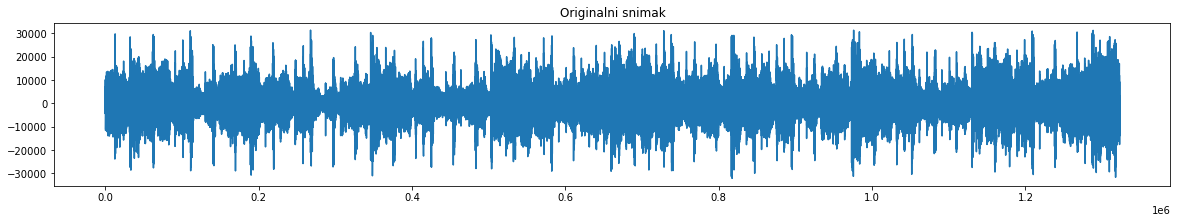

In [10]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data[:,0])
plt.title("Originalni snimak")

Text(0.5, 1.0, 'Sum')

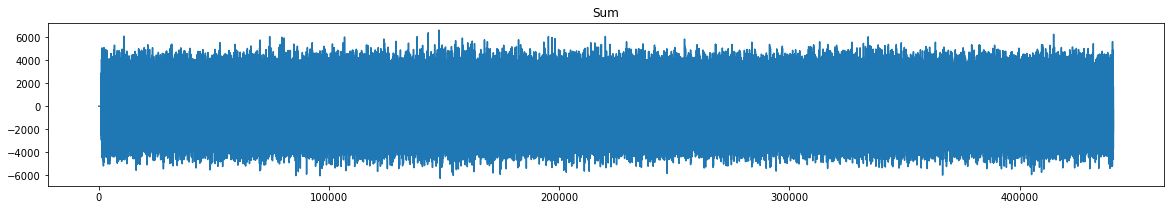

In [11]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(noise[:, 0])
plt.title("Sum")

Text(0.5, 1.0, 'Originalni sa sumom')

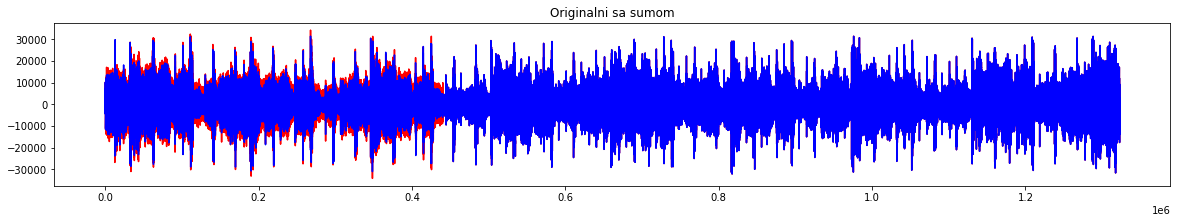

In [12]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(original_with_noise, color='red')
ax.plot(data[:, 0], color='blue')
plt.title("Originalni sa sumom")

### Ciscenje zvuka na oba kanala

In [13]:
noise_reduced = remove_noise(audio_clip=original_with_noise, noise_clip=noise[:,0], prop_decrease=1.0)
noise_reduced1 = remove_noise(audio_clip=original_with_noise1, noise_clip=noise[:,1], prop_decrease=1.0)

### Prikazivanje ociscenog zvuka

Text(0.5, 1.0, 'Bez suma')

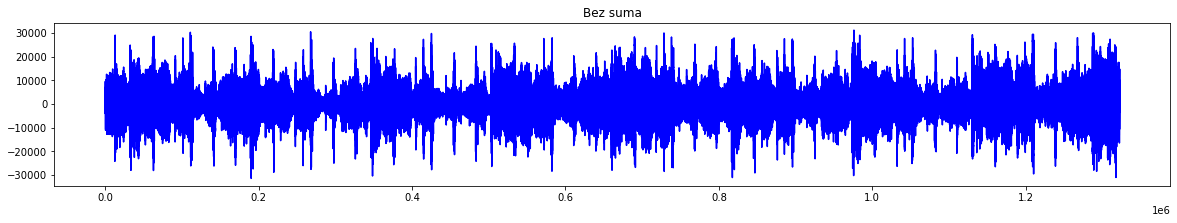

In [14]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(noise_reduced, color='blue')
plt.title("Bez suma")

### Bitan deo - Primena prozora na akumulirane greske pri uzorkovanju

Bez ovoga smo dobijali losiji zvuk nego pre ciscenja sa poznatim sumom koji se javlja pri ovoj gresci

In [15]:
# Resavanje curenja spektra prozorskim funkcijama
c = np.fft.fft(noise_reduced)
window = signal.windows.hamming(c.shape[0])
c = c * window
c1 = np.fft.fft(noise_reduced1)
window = signal.windows.hamming(c1.shape[0])
c1 = c1 * window

### Vracanje u vremenski domen oba kanala i spremanje za cuvanje snimka

In [16]:
left = np.fft.ifft(c).astype(data[:,0].dtype)
right = np.fft.ifft(c1).astype(data[:,1].dtype)
final = np.array([left, right]).T

<ipython-input-16-3eb7086455d9>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  left = np.fft.ifft(c).astype(data[:,0].dtype)
<ipython-input-16-3eb7086455d9>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  right = np.fft.ifft(c1).astype(data[:,1].dtype)


In [17]:
wavfile.write("Noise_reduced" + str(number) + ".wav", Fs, final)

In [18]:
window = signal.windows.hamming(original_with_noise.shape[0])
original_with_noise = np.fft.ifft(np.fft.fft(original_with_noise) * window).astype(data[:, 0].dtype)
window = signal.windows.hamming(original_with_noise1.shape[0])
original_with_noise1 = np.fft.ifft(np.fft.fft(original_with_noise1) * window).astype(data[:, 1].dtype)
original_with_noise_stereo = np.array([original_with_noise, original_with_noise1]).T

<ipython-input-18-c6c5f4aabdcf>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  original_with_noise = np.fft.ifft(np.fft.fft(original_with_noise) * window).astype(data[:, 0].dtype)
<ipython-input-18-c6c5f4aabdcf>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  original_with_noise1 = np.fft.ifft(np.fft.fft(original_with_noise1) * window).astype(data[:, 1].dtype)


In [19]:
wavfile.write("Song_with_noise" + str(number) + ".wav", Fs, original_with_noise_stereo)

In [20]:
from IPython import display

In [21]:
display.Audio(url='./bonobo.wav')

In [22]:
display.Audio(url='./Song_with_noise' + str(number) +'.wav')

In [23]:
display.Audio(url='./Noise_reduced' + str(number) +'.wav')